# Regularisierung

## Überblick

Bei Regressionsaufgaben taucht oft das Problem des Overfittings auf.
Dabei wird das zugrundeliegende Modell "zu genau" an die vorliegenden
Daten angepasst, was einerseits negative Auswirkungen auf die Generalisierung haben kann und andererseits zu extremer Empfindlichkeit gegenüber Messfehlern in den Daten führen kann.

Um diese Probleme zu beseitigen, benutzt man Regularisierungsansätze.
Über zusätzliche Nebenbedingungen wird versucht, Overfitting zu vermeiden.

Anhand eines einfachen Tomographieproblems werden verschiedene Regularisierer vorgestellt.

## Tomographie

Fast alle Tomographieverfahren in Medizin und Technik arbeiten nach dem gleichen
Grundprinzip:
   
- das zu untersuchende Objekt wird durchstrahlt und die Abschwächung
der Intensität nach Austritt aus dem Objekt gemessen, die
aufgrund unterschiedlicher Dichten im Objekt entsteht

- die Messung wird mehrfach wiederholt in dem das Objekt oder die Strahlenquelle
gedreht wird

- aus den für viele verschiedene Winkel erhaltenen Intensitätsmessungen
(sogenannten **Sinogrammen**) soll nun die Dichteverteilung im Objekt bestimmt werden

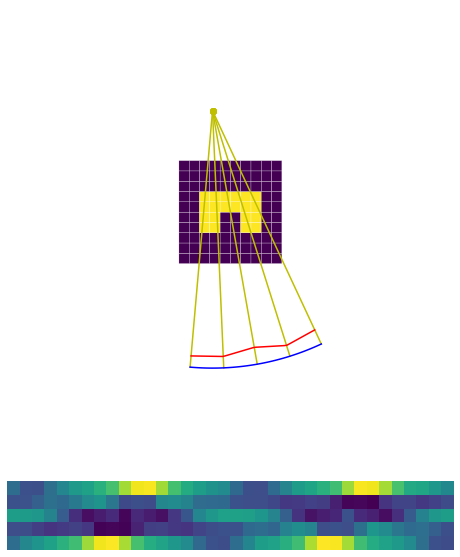

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML
from IPython.display import Math
%precision 5
np.set_printoptions(precision=4)


from DatenNotebooks.xrtomo12 import *

%matplotlib inline

_,_,t = tomo()
anim = HTML(t().to_jshtml());

In [2]:
anim

Um die Aufgabenstellung als Regressionsproblem formulieren zu können, machen wir die folgenden
(teilweise vereinfachenden) Annahmen:

- das zu untersuchende Objekt befindet sich immer im Einheitsquadrat
$[-\frac{1}{2},\frac{1}{2}] \times [-\frac{1}{2},\frac{1}{2}]$

- wir überziehen das Einheitsquadrat mit einem äquidistanten Gitter
mit $n_g$ Gitterzellen (Pixel) in jeder Koordinatenrichtung

- innerhalb einer Gitterzelle wird die Dichte unseres Objekts als konstant angenommen

- wir schicken $n_s$ Strahlen durch das Objekt und messen die Abschwächung
der Intensität für jeden dieser Strahlen

- die Messung wird für $n_w$ verschiedene Drehwinkel wiederholt

- wir gehen von einem linearen Modell aus, d.h. durchläuft ein
Strahl nacheinander zwei Zellen des Gitters, so addieren sich die Abschwächungen

Damit kann die Aufgabe wie folgt beschrieben werden:

- benutze die Information aus den Messdaten (Sinogramm) um die (innerhalb eines Pixels konstante) Dichte
in jedem Pixel unseres Gitters im Einheitsquadrat zu bestimmen

- die Dichtewerte der Pixel liefern dann ein Bild des Inneren unseres Objekts


Für die Rückrechnung benötigen wir noch
die Information, wie die Sinogramme für jedes einzelne Pixel aussehen.
Dazu müssen wir alle Messdaten für jedes einzelne Pixel ermitteln,
wenn die Dichte in diesem Pixel 1 und in allen anderen Pixeln 0 ist.
Diese Daten müssen für einen Tomographen nur einmal ermittelt werden
und können dann für die Bildrekonstruktion über Regression immer wieder verwendet werden

Wir betrachten exemplarisch das (ideale) Sinogramm eines Pixels

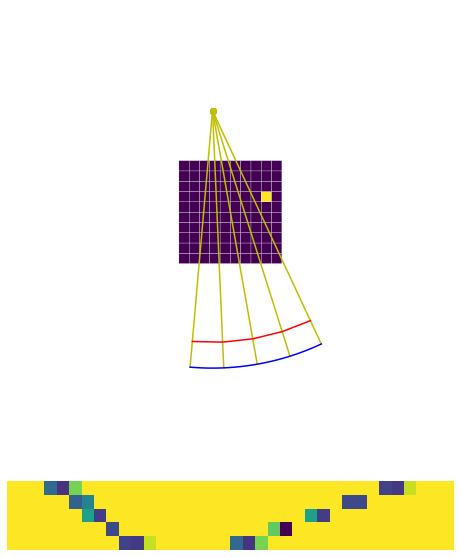

In [3]:
def pixeldichte(x,y):
    return float((0.3 <= x) * (x < 0.4) * (0.1 <= y) * (y < 0.2))

_, _ , t = tomo(sig0 = vectorize(pixeldichte), delta=0)

anim = HTML(t().to_jshtml())

Eine reale Messung würde aufgrund von Messfehlern ein etwas
verändertes Sinogramm liefern:

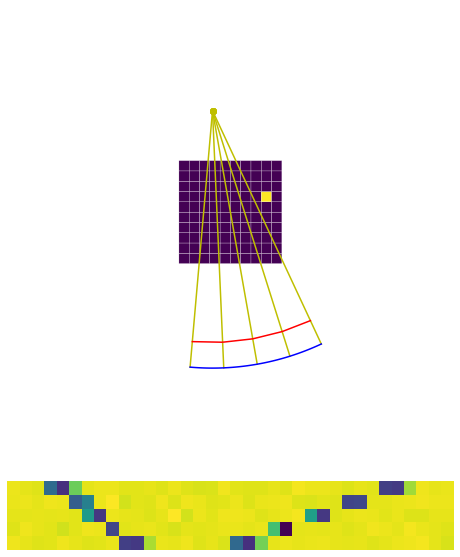

In [4]:
_, _, t = tomo(sig0 = vectorize(pixeldichte))

anim = HTML(t().to_jshtml())

In [5]:
anim

Aufgrund unserer Modellannahme sollte sich nun das für unser Objekt gemessene Sinogramm
als Linearkombination der Pixel-Sinogramme darstellen lassen.

Wandeln wir die Sinogramme in Vektoren der Dimension $m$ um 
und bezeichnen wir mit $x_j \in \mathbb{R}^m$, $j=1,\ldots,n$, 
das Pixel-Sinogramme zum $j$-ten Pixel bzw. mit
$y \in \mathbb{R}^m$ das Sinogramm unseres Körpers, so ergibt sich für die Pixelintensität $w \in \mathbb{R}^n$ das 
folgende lineare Regressionsproblem 
\begin{equation*} 
w^* = \text{argmin}\|Xw - y\|_2^2,
\quad
X = \big(x_1, \ldots, x_n\big) \in \mathbb{R}^{m \times n}.
\end{equation*}
Ordnen wir die einzelnen Komponenten von $w^*$ entsprechend an,
so erhalten wir (hoffentlich) ein Dichtebild des Inneren unseres Körpers.

## Lineare Regression ohne Regularisierung

Mit der oben benutzten Funktion `tomo` aus dem Package `xrtomo12` können sehr einfach die erforderlichen Daten erzeugt werden.
Wir betrachten zunächst den Doc-String von `tomo`

In [6]:
help(tomo)

Help on function tomo in module DatenNotebooks.xrtomo12:

tomo(sig0=<function sig0 at 0x7f12977cfb80>, ngitter=10, nstrahl=5, winkel=array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290, 300, 310, 320, 330, 340, 350]), quelle=<class 'DatenNotebooks.xrtomo12.zentral'>, delta=0.01, fout=None)
    |
    | 
    sig0    : Funktion die für (x,y) den Leitfähigkeitswert liefert
    ngitter : Gitterauflösung (in beide Richtungen gleich) auf [-0.5,0.5] x [-0.5,0.5]
    nstrahl : Anzahl der Strahlen für Quelle
    winkel  : array der Drehwinkel
    quelle  : zentral oder parallel
    delta   : std des Messrauschens
    fout    : Daten werden als float32 in fout.csv.gz komprimiert geschrieben
    
    Rückgabewert: X, y, Animationsfunktion
        
        a(rep = False, interval = 200)
        
        rep      : Repeat
        interval : Zeitabstand zwischen Frames



`tomo` besitzt unter anderem folgende Parameter:

- `sig0(x,y)` ist eine Funktion, die die Dichte im Innern des Körpers an (x,y) definiert (also die Information,
die wir später mit Regression möglichst präzise rekonstruieren wollen); `sig0` muss vektorisierbar sein,
d.h. auch auf numpy-arrays x,y arbeiten können

- `ngitter` definiert die Anzahl der Pixel pro Koordinatenrichtung

- `nstrahl` ist die Anzahl der Strahlen

- `winkel` eine Liste mit Winkeln, unter denen das Objekt durchleuchtet werden soll

- `quelle` definiert, ob die Strahlenquelle das Objekt `parallel` oder `zentral` durchleuchtet

- `delta` definiert die Standardabweichung des normalverteilten Messfehlers in den gemessenen Intensitäten

Wir generieren nun einen Datensatz *ohne Messfehler* auf $y$ und lösen das Regressionsproblem
mit Scikit-Learn

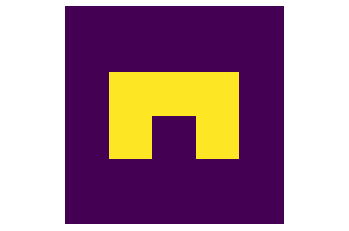

In [7]:
X, y, _ = tomo(delta = 0.0)

from sklearn import linear_model

modell = linear_model.LinearRegression(fit_intercept = False)
modell.fit(X, y.ravel())

w = modell.coef_

def plotReko(b):
    n = int(np.sqrt(b.shape[0]))
    
    plt.pcolor(b.reshape(n,n))
    plt.axis('equal')
    plt.axis('off')

plotReko(w)

Die Rekonstruktion ist perfekt (*inverse crime*).

Nun wiederholen wir das Ganze für die selbe Konstellation, dieses mal aber mit $1\%$ (relativem normalverteilten) Messfehler auf $y$.

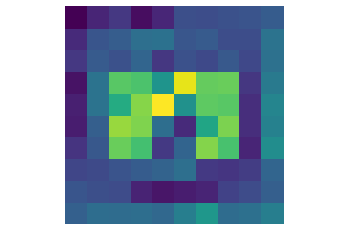

In [8]:
X, y, _ = tomo(delta = 0.01)

modell = linear_model.LinearRegression(fit_intercept = False)
modell.fit(X, y.ravel())

w = modell.coef_
plotReko(w)

Die Rekonstruktion ist eher unbefriedigend, offensichtlich wirken sich die Messfehler
in $y$ sehr nachteilig aus.

Die Ursache kann mit Hilfe der Singulärwertzerlegung leicht erklärt werden.
Wenn wir $\|X w - y\|_2^2$ minimieren, dann berechnen wir zu $X = U\Sigma V^T$ eigentlich
\begin{align*} 
w^* 
&= X^+y = V\Sigma^+U^Ty
\end{align*}
mit
\begin{align*} 
\Sigma^+ 
&= 
\begin{pmatrix}
\frac{1}{\sigma_1}\\
&\ddots \\
&& \frac{1}{\sigma_r}\\
&&& 0 \\
&&&& \ddots\\
&&&&&0
\end{pmatrix}
\in\mathbb{R}^{n \times m}.
\end{align*}
Existieren Singulärwerte $\sigma_k \ll \sigma_1$ (und ist $u_k^T y \ne 0$, was bei einem
messfehlerbehafteten $y$ eigentlich immer der Fall ist), so kann es durch die Kehrwertbildung
zu extremen Messfehlerverstärkungen kommen, die die Rekonstruktion komplett verfälschen können (**Overfitting**)

## PCA (TSVD)

Haben wir in unseren Daten $X$ Singulärwerte 
\begin{equation*} 
\sigma_1 \ge \sigma_{k} \ge \sigma_{k+1} \ge \ldots \ge \sigma_r >0,
\quad
\sigma_1 \gg \sigma_{k+1},
\end{equation*}
so bedeutet das, dass die entsprechenden Parameterkombinationen $v_{k+1}^T w,\ldots, v_r^T w$ nur sehr geringen Einfluss auf $y$ haben.
Deshalb kann man versuchen $X$ über TSVD/PCA durch einen entsprechend verkleinerten Datensatz $X_k$ zu ersetzen und mit diesem die Rekonstruktion durchzuführen.

Wir betrachten für unseren Fall zunächst den 
"Exlpained Variance Ration", 
also $\frac{\sigma_i^2}{\text{Var}(X)}$

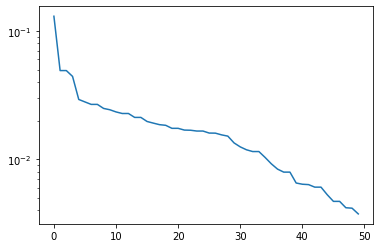

In [9]:
Xfro = spa.linalg.norm(X, ord = 'fro')

U, s, VT = spa.linalg.svds(X, 50)
ii = s.argsort()[::-1]

exp_var = s[ii]**2
exp_var_ratio = exp_var / Xfro**2

plt.semilogy(exp_var_ratio);

bzw. die kumulierte Summe davon

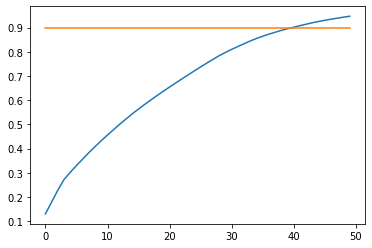

In [10]:
varcum = exp_var_ratio.cumsum()
#varcum
plt.plot(varcum)
plt.plot(0.9 * np.ones(varcum.shape));

Mehr als 90 Prozent der Varianz von X erreichen wir schon mit wenigen Hauptkomponenten

In [11]:
ncut = np.argwhere(varcum > 0.9).min()
ncut

40

Als Rekonstruktion erhalten wir

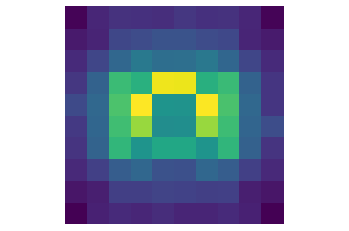

In [12]:
iicut = ii[:ncut]
wk = VT[iicut,:].T.dot(s[iicut] * U.T[iicut].dot(y))
plotReko(wk)

Sie ist etwas besser als oben, insbesondere ist sie nicht mehr so "verrauscht". Allerdings sind die harten Kontraste
an der Trennfläche Körper/Umgebung sehr verwaschen.

## Ridge Regression (Tikhonov-Regularisierung) 

Ein anderer Ansatz um dem Problem des Overfittings zu begegnen wird bei Ridge Regression verfolgt.
Wir bestimmen jetzt die Rekonstruktion $w$ durch Minimieren von	
\begin{equation*} 
\| X w - y\|_2^2 + \alpha \|w\|_2^2
\end{equation*}
wobei $\alpha > 0$ ein vom Benutzer zu wählender "Regularisierungsparameter" ist.

Mit $\alpha$ gewichtet man, ob man mehr Wert auf möglichst kleine Residuen ($\alpha > 0$  nahe bei $0$) oder mehr
Wert auf "kleine" Parameter $w$ ($\alpha > 0$  groß) legt, um damit dem Overfitting entgegen zu wirken.

Der Vorteil bei diesem Zugang ist, dass man keine Singulärwertzerlegung von $X$ benötigt. Dazu benutzt man
\begin{align*} 
\| X w - y\|_2^2 + \alpha \|w\|_2^2
&=
\Big\| 
\begin{pmatrix}
X \\ \sqrt{\alpha} I
\end{pmatrix}
w
-
\begin{pmatrix}
y \\ 0
\end{pmatrix}
\Big\|_2^2\\
&=
\| \tilde{X} w - \tilde{y}\|_2^2
\end{align*}
und die zugehörige Normalgleichung ist
\begin{equation*} 
\tilde{X}^T \tilde{X }w = \tilde{X}^T\tilde{y}
\end{equation*}
bzw.
\begin{equation*} 
\big(X^T X + \alpha I \big)w = X^Ty.
\end{equation*}
Für $\alpha>0$ ist die Systemmatrix spd
und das Gleichungssystem ist eindeutig lösbar.

### Fit mit Defaultparametern

Mit `linear_model.Ridge` führen wir eine Ridge Regression mit 
Default-Parameter $\alpha=1$ durch.

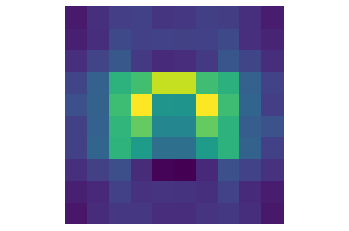

In [13]:
ridge = linear_model.Ridge(fit_intercept = False)

ridge.fit(X, y)

w = ridge.coef_
plotReko(w)

Die Rekonstruktion ist ähnlich zu der bei PCA/TSVD.

### Fit mit Parameterwahl

Die Wahl des Parameters $\alpha$ im letzten Abschnitt ist mit Sicherheit nicht sehr geschickt. Deshalb sehen wir uns jetzt an,
wie sich 
die Residuen des gefitteten linearen Modells (MSE) mit $\alpha$
verändern.

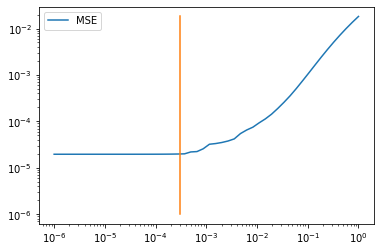

In [14]:
from sklearn.metrics import mean_squared_error

al = np.logspace(-6,0)

mse = []

for a in al:
    ridge = linear_model.Ridge(alpha = a, fit_intercept = False)
    ridge.fit(X, y)
    mse.append(mean_squared_error(y, ridge.predict(X))) 
    
mse = np.array(mse)

plt.loglog(al, mse, label = "MSE")
plt.loglog([3e-4, 3e-4], [1e-6, mse.max()])
plt.legend(loc = 0);

Der MSE-Wert fällt mit kleiner werdendem $\alpha$ zunächst stark
ab, um dann fast zu stagnieren.
Dieses Stagnieren deutet auf einsetzendes Overfitting hin.
Deshalb bietet es sich an, $\alpha$ einerseits möglichst groß zu wählen
um Overfitting zu vermeiden, andererseits aber klein genug, damit
das Residuum und damit der Fit genau genug ist.

<IPython.core.display.Math object>

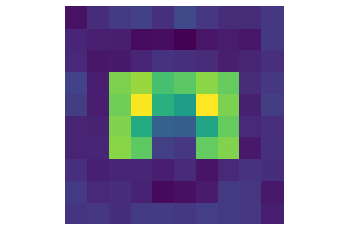

In [15]:
alpha = 3e-4
ridge = linear_model.Ridge(alpha, fit_intercept = False)
ridge.fit(X, y)
w = ridge.coef_
plotReko(w)

Math(r'\alpha = {}'.format(alpha))

Es gibt viele Parameterwahlstrategien, um $\alpha$ automatisch bestimmen zu lassen (Diskrepanz-Prinzip nach Morozov, L-Curve, Cross-Validation etc.). 
Scikit-learn enthält z.B. `linear_model.RidgeCV`, das 
Cross-Validation dafür benutzt:
  
  - unterteile die Daten in $k$ möglichst gleich große
    Teilmengen $T_i$, $i=1,\ldots,k$ (unter Umständen **stratifiziert**, also mit annähernd
    gleicher Verteilung)
  
  - führe $k$ Fits durch, wobei alle Daten außer einem $T_i$
    benutzt werden
  
  - würde man nun wie oben das Residuum zu den für die Anpassung
  benutzten Daten berechnen, dann
  würde man bei Overfitting relativ kleine Werte erhalten
  (**in-sample error**)
  
  - deswegen benutzt man nun den nicht verwendeten Datensatz
  $T_i$ um die Qualität der Anpassung zu prüfen (**out-of-sample error**)
  
  - enthalten alle $T_i$ nur genau ein Element,
  so spricht man von **Leave-One-Out-Cross-Validation**
  

Cross-Validation scheint auf den ersten Blick sehr aufwendig zu sein (Leave-One-Out-Cross-Validation erfordert so viele Fits wie Daten vorhanden sind).
Allerdings kann für Ridge Regression durch eine
geschickte Implementierung der Mehraufwand soweit reduziert
werden, dass er nicht mehr ins Gewicht fällt.

Die Methode `linear_model.RidgeCV`
benutzt als Default solch eine Implementierung
der Leave-One-Out-Cross-Validation.

<IPython.core.display.Math object>

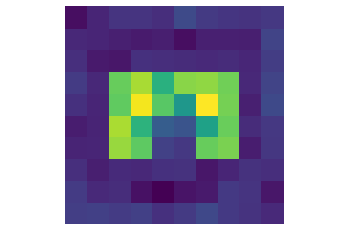

In [16]:
al = np.logspace(-5,-2)
ridgecv = linear_model.RidgeCV(alphas = al, fit_intercept = False)

ridgecv.fit(X, y)

display(Math(r'\alpha = {:f}'.format(ridgecv.alpha_)))

w = ridgecv.coef_
plotReko(w)

## Lasso (Tikhonov mit $L^1$-Strafterm)

Statt 
$\| X w - y\|_2^2 + \alpha \|w\|_2^2$
minimiert man nun
\begin{equation*} 
\frac{1}{2m}\| X w - y\|_2^2 + \alpha \|w\|_1
\end{equation*}
wobei $\alpha > 0$ wieder ein vom Benutzer zu wählender  Regularisierungsparameter ist.

Im Gegensatz zum letzten Abschnitt kann man für dieses Problem keine
einfache, geschlossene Lösung angeben.


In Scikit-Learn ist dieses Verfahren (mit Parameterwahl über Cross-Validation) in der Methode `linear_model.LassoCV` implementiert.
Benutzt man `LassoCV` ohne weitere Parameter, so wird
$\alpha$ automatisch ermittelt.

<IPython.core.display.Math object>

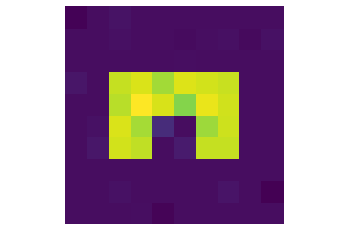

In [17]:
lassocv = linear_model.LassoCV(fit_intercept = False, cv = 5)

lassocv.fit(X, y)

display(Math(r'\alpha = {:e}'.format(lassocv.alpha_)))

w = lassocv.coef_
plotReko(w)

Wir erhalten deutlich stärkere Kontraste, der Hintergrund ist
sehr viel gleichmäßiger als in den vorherigen Rekonstruktionen.

### Subgradienten, Sparsity

Betrachten wir die rekonstruierten Parameter genauer, so fällt auf,
dass viele der Parameter identisch $0$ sind.

In [18]:
w

array([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  4.6363e-03, -2.4641e-02,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        1.6704e-03,  0.0000e+00,  1.4197e-02, -0.0000e+00, -0.0000e+00,
       -0.0000e+00, -0.0000e+00,  2.4671e-02,  0.0000e+00, -3.6158e-02,
        0.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  3.1670e-02,  1.0098e+00,  9.7667e-01,  0.0000e+00,
        4.5634e-02,  9.8698e-01,  9.8596e-01,  0.0000e+00,  0.0000e+00,
       -0.0000e+00,  1.3011e-02,  1.0227e+00,  9.3558e-01,  1.0309e-01,
        0.0000e+00,  9.2004e-01,  9.9805e-01,  0.0000e+00,  0.0000e+00,
        0.0000e+00, -0.0000e+00,  9.6475e-01,  1.0846e+00,  1.0147e+00,
        8.7460e-01,  1.0462e+00,  1.0038e+00,  0.0000e+00,  0.0000e+00,
        2.8481e-02,  0.0000e+00,  9.8580e-01,  1.0207e+00,  9.2846e-01,
        1.0251e+00,  1.0094e+00,  9.8845e-01,  0.0000e+00,  2.93

Dies ist kein Zufall. Wir untersuchen jetzt die Eigenschaften der
Minima unserer Zielfunktion
\begin{equation*} 
f(w) 
= \frac{1}{2m}\| X w - y\|_2^2 + \alpha \|w\|_1
\end{equation*}
genauer.
$f$ ist für $\alpha \ge 0$ konvex, wegen 
$\|w\|_1 = \sum_{i=1}^n |w_i|$ ist $f$ aber nicht differenzierbar.

Man kann allerdings den Differenzierbarkeitsbegriff so erweitern, dass man ihn auch in dieser Situation anwenden
kann.
Für $f$ konvex definiert man den **Subgradienten**  $\partial f (w)$ an der Stelle $w$ als die Menge aller Vektoren
$d$ mit
\begin{equation*} 
f(v) \ge f(w) + (d, v-w)_2 \quad \forall v\in U,
\end{equation*}
wobei $U$ eine offene Umgebung von $w$ ist.

Anschaulich beschreibt man damit alle linear affinen Abbildungen auf $U$, die den Graphen von $f$ an $(w,f(w))$ berühren und in $U$ nicht oberhalb des Graphen von $f$ verlaufen ("alle Tangenten unterhalb").

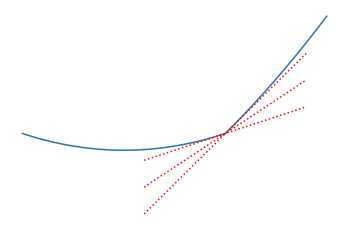

In [19]:
f  = lambda w : w*w + np.abs(w - 1)
tl = lambda w : w
tr = lambda w : 3*(w - 1) + 1
tm = lambda w : 2*(w - 1) + 1

w  = np.linspace(0, 1.5, 1000)
wt = np.linspace(0.6, 1.4, 2)

plt.plot(w, f(w))
plt.plot(wt, tl(wt), 'r:')
plt.plot(wt, tr(wt), 'r:')
plt.plot(wt, tm(wt), 'r:')
plt.axis('off');

Für konvexes $f,g$ hat der Subgradient $\partial f(w)$ folgende Eigenschaften:

- er existiert, d.h. $\partial f(w) \ne \emptyset \ \forall w$

- $\partial (f+g)(w) = \partial f(w) + \partial g(w)$

- besteht er nur aus einem Element, dann ist $f$ differenzierbar in $w$  und der gewöhnliche und der Subgradient sind identisch
  
- $w$ minimiert die konvexe Funktion $f$ genau dann, wenn $0\in\partial f(w)$

Als Beispiel betrachten wir die konvexe Funktion $f(w) = |w|$.
Für $w\ne 0$ ist $f$ differenzierbar, so dass dort die 
gewöhnliche Ableitung mit dem Subgradienten übereinstimmt. 
Alle Geraden 
durch $(0, f(0))$ die (lokal) nicht oberhalb des Graphen von $f$
verlaufen haben eine Steigung in $[-1,1]$. Somit ist
\begin{equation*} 
\partial|w|
=
\begin{cases}
-1 & w < 0\\
[-1,1] & w = 0\\
1 & w > 0
\end{cases}
.
\end{equation*}

Betrachten wir nun für $\alpha \ge 0$ die Lasso-Zielfunktion
\begin{align*} 
f(w) 
&= \frac{1}{2m}\| X w - y\|_2^2 + \alpha \|w\|_1\\
&= \frac{1}{2m}(X w - y, X w - y)_2 + \alpha \|w\|_1
\end{align*}
für den einfachsten Fall $n=1$, d.h. $w\in\mathbb{R}$,
$X = x \in\mathbb{R}^m$,
$y \in\mathbb{R}^m$, also
\begin{equation*} 
f(w) 
= \frac{1}{2m}(x w - y, x w - y)_2 + \alpha |w|.
\end{equation*}
Der erste Summand ist (klassisch) differenzierbar, so dass wir als Subgradienten
\begin{equation*} 
\partial f(w)
=
\frac{1}{m}\big((x,x)_2 w - (x,y)_2\big) + \alpha
\begin{cases}
-1 & w < 0\\
[-1,1] & w = 0\\
1 & w > 0
\end{cases}
\end{equation*}
erhalten.
Um jetzt das Minimum von $f$ zu bestimmen, überprüfen wir die Bedingung $0 \in \partial f(w)$.

Für $x = 0$ ist $\partial f(w) = \partial |w|$ und $0 \in \partial f(w)$ genau dann, wenn $w=0$.

Sei jetzt $x\ne 0$. Dann folgt aus $0 \in \partial f(w)$
\begin{equation*} 
(x,x)_2 w - (x,y)_2 + \alpha d m= 0,
\quad
d \in \begin{cases}
\{-1\} & w < 0\\
[-1,1] & w = 0\\
\{1\} & w > 0
\end{cases}
\end{equation*}
bzw. wegen $x\ne 0$
\begin{equation*} 
w = \frac{(x,y)_2 - \alpha dm}{(x,x)_2}.
\end{equation*}

Für $w<0$ ist $d=-1$ also
\begin{equation*} 
w = \frac{(x,y)_2 + \alpha m}{(x,x)_2} < 0
\end{equation*}
und somit 
\begin{equation*} 
w = \frac{(x,y)_2 + \alpha m}{(x,x)_2},
\quad\text{für}\quad 
(x,y)_2 < -\alpha m.
\end{equation*}
Analog ergibt sich für $w>0$
\begin{equation*} 
w = \frac{(x,y)_2 - \alpha m}{(x,x)_2},
\quad\text{für}\quad 
(x,y)_2 > \alpha m.
\end{equation*}
Für $w=0$ ist
\begin{equation*} 
(x,y)_2 = \alpha d m, \quad d\in[-1,1],
\end{equation*}
d.h.
\begin{equation*} 
-\alpha m \le (x,y)_2 \le \alpha m.
\end{equation*}

Insgesamt erhalten wir damit folgende Lösung
\begin{equation*} 
w^*
= \text{argmin}_{w\in\mathbb{R}} f(w)
=
\begin{cases}
\frac{(x,y)_2 + \alpha m}{(x,x)_2} & (x,y)_2 < -\alpha m\\
0 & -\alpha m \le (x,y)_2 \le \alpha m \\
\frac{(x,y)_2 - \alpha m}{(x,x)_2} & (x,y)_2 > \alpha m
\end{cases}.
\end{equation*}
Für $\alpha\downarrow 0$ erhält man das Minimum $w^*$ von $\frac{1}{2}(x w - y, x w - y)_2$, nämlich
\begin{equation*} 
\frac{(x,y)_2 }{(x,x)_2}.
\end{equation*}
Mit wachsendem $\alpha > 0$ verändert man diesen Wert bzw. setzt ihn auf $0$.

Kommen wir nun zurück zur allgemeinen Lasso-Zielfunktion,
d.h. $X\in\mathbb{R}^{m\times n}$, $X\in\mathbb{R}^n$,

\begin{equation*} 
f(w) 
= \frac{1}{2m}\| X w - y\|_2^2 + \alpha \|w\|_1.
\end{equation*}
Der Subgradient ist
\begin{equation*} 
\partial f(w) 
= \frac{1}{m} X^T(X w - y) + \alpha \, \partial \|w\|_1.
\end{equation*}
und mit $r = X w - y$ erhalten wir für die $k$-te Komponente
\begin{equation*} 
\partial_{w_k} f(w) 
= \frac{1}{m} (x_k, r) + \alpha \, \partial |w_k|.
\end{equation*}
Nehmen wir nun an, dass $w$ ein Minimierer von $f$ ist mit
$w_k = 0$. Dann ist $0\in\partial_{w_k} f(w)$, d.h.
\begin{equation*} 
0 
= \frac{1}{m} (x_k, r) + \alpha \, d,
\quad
d\in [-1,1],
\end{equation*}
also
\begin{equation*} 
|(x_k, r)| \le m \,\alpha.
\end{equation*}

Im Vergleich dazu liefert die (differenzierbare) Tikhonov-Zielfunktion
\begin{equation*} 
f(w) 
= \| X w - y\|_2^2 + \alpha \|w\|_2^2
\end{equation*}
in der gleichen Situation ($w_k = 0$)
\begin{equation*} 
0 
= \partial_{w_k} f(w) 
= 2 (x_k, r)_2 + 2\alpha \, w_k
= 2 (x_k, r)_2,
\end{equation*}
also $(x_k, r)=0$ *unabhängig* von $\alpha$.

Damit folgt, dass für einen Optimierer $w$ von $f(w)$
die Komponente $w_k$ nur dann $0$ sein kann, falls

- bei Tikhonov $(x_k,r) = 0$ ist, also $r = Xw-y$ senkrecht
  auf $x_k$ steht
  
- bei Lasso $|(x_k, r)_2| \le m \,\alpha$ ist, d.h. der Winkel
  $\varphi_k$ zwischen $x_k$ und $r$ der Bedingung
  \begin{equation*} 
  |\cos(\varphi_k )|
  = \Big|\frac{(x_k, r)_2}{\|x_k\|_2\:\|r\|_2}\Big|
  \le \frac{m \,\alpha}{\|x_k\|_2\:\|r\|_2}
  \end{equation*}
  genügt.

Bei Tikhonov müssen $x_k$ und $r$ immer senkrecht aufeinander
stehen. Bei Lasso werden hingegen in Abhängigkeit von $\alpha$
Abweichungen davon zugelassen.
Offensichtlich ist die Bedingung bei Lasso für $\alpha > 0$ weniger restriktiv. Für $\alpha$ groß genug kann sie immer eingehalten werden.

Bei Lasso kann man also über $\alpha$ steuern, wie viele
Komponenten von $w$ identisch $0$ sind, d.h. man beeinflusst
damit, wie "sparse" $w$ ist.

### Coordinate Descent

In diesem Abschnitt betrachten wir nun das numerische Verfahren,
mit dem Scikit-Learn den Minimierer von
\begin{equation*} 
f(w) 
= \frac{1}{2m}\| X w - y\|_2^2 + \alpha \|w\|_1
\end{equation*}
berechnet.

Der Subgradient von $f$ ist
\begin{equation*} 
\partial f(w) 
= \frac{1}{m} X^T(X w - y) + \alpha \, \partial \|w\|_1.
\end{equation*}
Wegen
\begin{equation*} 
\partial_{w_k} \|w\|_1
= \partial_{w_k} \sum_{j=1}^n |w_j|
= \partial_{w_k} |w_k|
\end{equation*}
erhalten wir als $k$-te Komponente 
\begin{equation*} 
\partial_{w_k} f(w) 
= \frac{1}{m} x_k^T \big(\sum_{j=1}^n x_j w_j - y \big) + \alpha \,   \partial_{w_k} |w_k|.
\end{equation*}
Benutzen wir
\begin{equation*} 
y_k = y - \sum_{j\ne k}^n x_j w_j
\end{equation*}
so erhalten wir schließlich
\begin{equation*} 
\partial_{w_k} f(w) 
= \frac{1}{m} \big( (x_k, x_k)_2 w_k -  (x_k, y_k)_2 \big)+ \alpha \, \partial_{w_k} |w_k|.
\end{equation*}

Halten wir $w_j$, $j\ne k$ fest und betrachten $f$ als Funktion in $w_k$, dann minimieren wir $f$ in Richtung
$w_k$ , falls wir
\begin{equation*} 
0 \in \partial_{w_k} f(w) 
= \frac{1}{m} \big( (x_k, x_k)_2 w_k -  (x_k, y_k)_2 \big)+ \alpha \, \partial_{w_k} |w_k|
\end{equation*}
auflösen können. Dies ist aber identisch mit dem oben gelösten Problem
im Fall $n=1$.
Wir erhalten also
\begin{equation*} 
w_k^*
= \text{argmin}_{w_k\in\mathbb{R}} f(w)
=
\begin{cases}
\frac{(x_k,y_k)_2 + m\alpha}{(x_k,x_k)_2} & (x_k,y_k)_2 < -m\alpha\\
0 & -m \alpha \le (x_k,y_k)_2 \le m\alpha\\
\frac{(x_k,y_k)_2 - m\alpha}{(x_k,x_k)_2} & (x_k,y_k)_2 > m\alpha
\end{cases}.
\end{equation*}

Diese eindimensionalen Optimierungsprobleme entlang der einzelnen Koordinaten-Richtung $w_k$
sind also einfach zu lösen.
Beim **Coordinate Descent** Verfahren wiederholt man einfach zyklisch diese Abstiege entlang der
Richtungen $w_1,\ldots,w_n$.

Wir wenden das Verfahren wieder auf das Tomographieproblem an
und benutzen dabei für $\alpha$ den Wert den wir oben
mit Scikit-Learn ermittelt hatten.

<IPython.core.display.Math object>

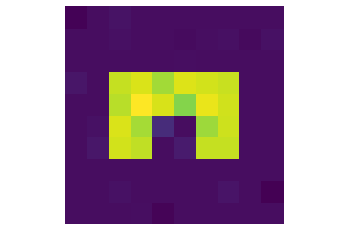

In [20]:
def CDsimpel(w0, X, y, alpha = 1e-4, nit = 300):
    m, n = X.shape
    w = w0.copy()
    
    ma = m * alpha
    for it in range(nit):
        for k in range(n):
            xk = X[:,k].toarray().ravel()
            yk = y - X.dot(w) + xk * w[k]
            
            xkxk = xk.dot(xk)
            xkyk = xk.dot(yk)
            

            if   xkyk < -ma:
                 w[k] = (xkyk + ma) / xkxk
            elif xkyk > ma:
                 w[k] = (xkyk - ma) / xkxk
            else:
                 w[k] = 0.0
    return(w)

w0 = np.ones(X.shape[1])

alpha_cd = lassocv.alpha_

w = CDsimpel(w0, X, y, alpha_cd)

display(Math(r'\alpha = {:e}'.format(alpha_cd)))

plotReko(w)

Unser Rekonstruktion sieht der von Scikit-Learn sehr ähnlich:

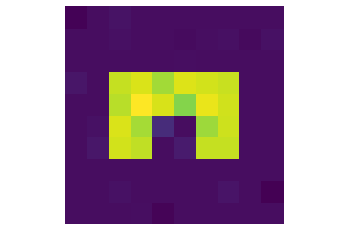

In [21]:
plotReko(lassocv.coef_)

Das gilt auch für die Zahlenwerte der rekonstruierten Parameter.

In [22]:
w

array([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  4.6413e-03, -2.4627e-02,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        1.6543e-03,  0.0000e+00,  1.4168e-02,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  2.4666e-02,  0.0000e+00, -3.6135e-02,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  3.1676e-02,  1.0097e+00,  9.7668e-01,  0.0000e+00,
        4.5570e-02,  9.8703e-01,  9.8596e-01,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  1.3013e-02,  1.0227e+00,  9.3561e-01,  1.0296e-01,
        0.0000e+00,  9.2015e-01,  9.9805e-01,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  9.6476e-01,  1.0846e+00,  1.0147e+00,
        8.7480e-01,  1.0462e+00,  1.0038e+00,  0.0000e+00,  0.0000e+00,
        2.8494e-02,  0.0000e+00,  9.8581e-01,  1.0207e+00,  9.2857e-01,
        1.0251e+00,  1.0094e+00,  9.8847e-01,  0.0000e+00,  2.91

## Zusammenfassung

Anhand eines Tomographieproblems haben wir die folgenden Regularisierer betrachtet:

- PCA (TSVD): 
    
    - benutze statt $\mathbb{R}^{m \times n} \ni X=U_r\Sigma_r V_r^T$ die abgeschnittene Variante
      $X=U_k\Sigma_k V_k^T$, $k \le r$
      
    - $k$ ist der Regularisierungsparameter
    
    - numerischer Aufwand: benötige (partielle) SVD
    
    
- Ridge Regression (Tikhonov-Regularisierung):

    - löse statt $X^TX w = X^T y$ das modifizierte 
      Normalgleichungssystem 
      \begin{equation*} \big(X^TX + \alpha I\big) w_\alpha = X^T y\end{equation*}
      
    - dies ist äquivalent zu
      \begin{equation*}  
      w_\alpha = \text{argmin}_w \big( \|Xw - y\|_2^2 + \alpha \|w\|_2^2 \big)
      \end{equation*}
      
    - $\alpha > 0$ ist der Regularisierungsparameter


- Lasso (Tikhonov mit $L^1$-Strafterm):

    - $w_\alpha = \text{argmin}_w \big(\frac{1}{2m} \|Xw - y\|_2^2 + \alpha \|w\|_1 \big)$
    
    - über den Regularisierungsparameter $\alpha > 0$ kann man Sparsity von $w_\alpha$ regulieren
    
    - im Gegensatz zu Ridge Regression kann das Problem nicht so umformuliert werden,
      dass es mit endlich vielen Operationen lösbar ist
    
    - $w_\alpha$ wird iterativ, z.B. mit Coordinate Descent, berechnet